In [11]:
%matplotlib notebook
import pandas as pd
import numpy as np
import stelardatafile as sdf
import matplotlib.pyplot as plt

In [5]:
polymer=sdf.StelarDataFile('297K.sdf',r'data')
polymer.sdfimport()
datas = polymer.datas

escape
145 experiments read


In [8]:
### preprocessing of the data experiment number ie=1
ie=1
parameters=polymer.getparameter(ie)
bs=int(parameters['BS'])
try:
    nblk=int(parameters['NBLK'])
except:
    nblk=1;
ns=int(parameters['NS'])
try:
    dw=parameters['DW']*1e-6 #dwell time is in [mu s]
except:
    dw=1
temperature=parameters['TEMP']
fid=pd.DataFrame(polymer.getdata(ie),index=np.linspace(dw,dw*bs*nblk,bs*nblk),
                 columns=['real', 'im'])/ns
fid['abs']=( fid['real']**2 + fid['im']**2 )**0.5 # last two lines may represent a seperate method


<IPython.core.display.Javascript object>


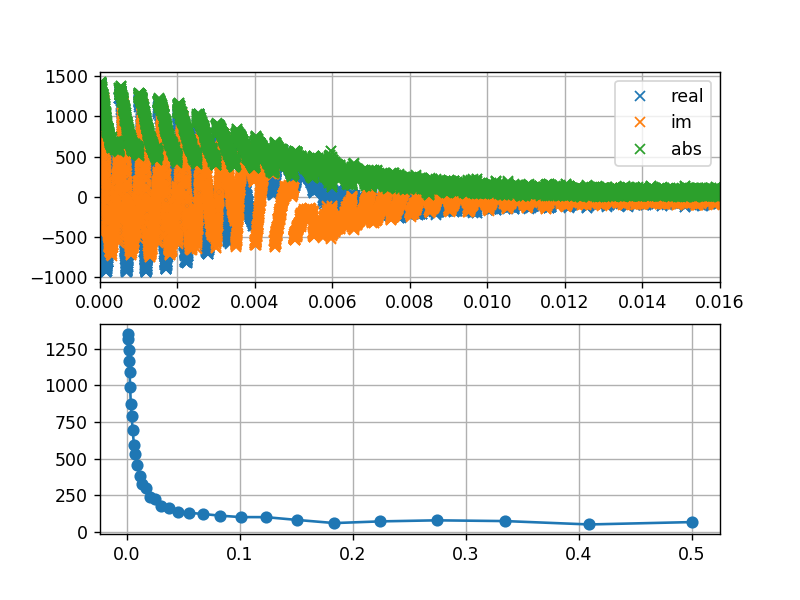

In [17]:
tau=np.logspace(-3,np.log10(5*parameters['T1MX']),nblk) #as a dummy
startpoint=int(0.05*bs)-1
endpoint=int(0.1*bs)
phi=np.zeros(nblk)
for blk in range(nblk):
    start=startpoint + blk * bs
    end=endpoint + blk * bs
    phi[blk]=fid['abs'].iloc[start:end].sum() / (endpoint-startpoint)

fig, axes = plt.subplots(2)
fid.plot(marker='x',linestyle='none', ax=axes[0])
axes[1].plot(tau,phi, '-o')
for ax in axes:
    ax.grid('on')